In [ ]:
from __future__ import print_function
import os
from os.path import splitext, join, isfile, isdir, basename
import argparse
import numpy as np
from scipy import misc, ndimage
from keras import backend as K
from keras.models import model_from_json, load_model
import tensorflow as tf
import layers_builder as layers
from glob import glob
from utils import utils
from keras.utils.generic_utils import CustomObjectScope
import cv2
import math

In [2]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt

from imageio import imread
# These are the means for the ImageNet pretrained ResNet
DATA_MEAN = np.array([[[123.68, 116.779, 103.939]]])  # RGB order

In [3]:
img_test = None

In [5]:
class PSPNet(object):
    """Pyramid Scene Parsing Network"""

    def __init__(self, nb_classes, resnet_layers, input_shape, weights):
        self.input_shape = input_shape
        self.num_classes = nb_classes
        
        json_path = join("weights", weights + ".json")
        h5_path = join("weights", weights + ".h5")       
        
        if os.path.isfile(json_path) and os.path.isfile(h5_path):
            
            # with CustomObjectScope({'Interp': layers.Interp}):
            with open(json_path) as file_handle:
                self.model = model_from_json(file_handle.read())
            self.model.summary()
            self.model.load_weights(h5_path)
        
            
    def predict_multi_scale(self, img, flip_evaluation, sliding_evaluation, scales):
        """Predict an image by looking at it with different scales."""

        full_probs = np.zeros((img.shape[0], img.shape[1], self.num_classes))
        h_ori, w_ori = img.shape[:2]

        print("Started prediction...")
        for scale in scales:
            print("Predicting image scaled by %f" % scale)
            scaled_img = misc.imresize(img, size=scale, interp="bilinear")

            scaled_probs = self.predict(scaled_img, flip_evaluation)

            # scale probs up to full size
            # visualize_prediction(probs)
            print(scale)
            print(scaled_probs.shape)
            
            probs = cv2.resize(scaled_probs, (w_ori, h_ori))
            print(probs.shape)
            img_test = probs
#             plt.imshow(probs)
            full_probs += probs
        full_probs /= len(scales)
        print("Finished prediction...")

        return full_probs
    
    def predict(self, img, flip_evaluation=False):
        """
        Predict segementation for an image.
        Arguments:
            img: must be rowsxcolsx3
        """

        if img.shape[0:2] != self.input_shape:
            img = misc.imresize(img, self.input_shape)

        img = img - DATA_MEAN
        img = img[:, :, ::-1]  # RGB => BGR
        img = img.astype('float32')
        
        print('iiiiiiiiiin predict')
        print(img.shape)
        assert img.shape == (self.input_shape[0], self.input_shape[1], 3)
        print(img.shape)
        
        prediction = self.model.predict(np.expand_dims(img, 0))
        print('prediction shape: ', prediction.shape)
        print('prediction[0].shape: ', prediction[0].shape)
        prediction = prediction[0]

        return prediction

    

In [6]:
class PSPNet101(PSPNet):
    """Build a PSPNet based on a 101-Layer ResNet."""

    def __init__(self, nb_classes, weights, input_shape):
        PSPNet.__init__(self, nb_classes=nb_classes, resnet_layers=101,
                        input_shape=input_shape, weights=weights)


In [11]:
from matplotlib import pyplot as plt
%matplotlib inline
def main():
    # Handle input and output args
    model = 'pspnet101_voc2012'
    input_path = 'example_images/2007_000847.jpg'
    images = [input_path]
    outputdir = 'output'
    output_file = 'test1.jpg'
    multi_scale = False
    flip = True
    sliding = False
    
    # Predict
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'

    sess = tf.compat.v1.keras.backend.get_session()
    K.set_session(sess)

    with sess.as_default():
            
        if "voc2012" in model:
            pspnet = PSPNet101(nb_classes=21, input_shape=(473, 473),
                               weights=model)
            
    
        EVALUATION_SCALES = [1.0]
        if multi_scale:
            EVALUATION_SCALES = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]  # must be all floats! Taken from original paper

        for i, img_path in enumerate(images):
            print("Processing image {} / {}".format(i + 1, len(images)))
            img = imread(img_path, pilmode='RGB')
            
            probs = pspnet.predict_multi_scale(img, flip, sliding, EVALUATION_SCALES)
            
            cm = np.argmax(probs, axis=2)
            pm = np.max(probs, axis=2)
            print('Segments')
            plt.imshow(cm)
            plt.show()
            print('Probs')
            plt.imshow(pm)
            plt.show()
            
            colored_class_image = utils.color_class_image(cm, model)
            alpha_blended = 0.5 * colored_class_image + 0.5 * img
            print('colored_class_image')
            plt.imshow(colored_class_image)
            plt.show()
            
            
            filename, ext = splitext(output_file)

            misc.imsave(filename + "_seg_read" + ext, cm)
            misc.imsave(filename + "_seg" + ext, colored_class_image)
            misc.imsave(filename + "_probs" + ext, pm)
            misc.imsave(filename + "_seg_blended" + ext, alpha_blended)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 473, 473, 3)  0                                            
__________________________________________________________________________________________________
conv1_1_3x3_s2 (Conv2D)         (None, 237, 237, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
conv1_1_3x3_s2_bn (BatchNormali (None, 237, 237, 64) 256         conv1_1_3x3_s2[0][0]             
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 237, 237, 64) 0           conv1_1_3x3_s2_bn[0][0]          
__________________________________________________________________________________________________
conv1_2_3x

Processing image 1 / 1
Started prediction...
Predicting image scaled by 1.000000
iiiiiiiiiin predict
(473, 473, 3)
(473, 473, 3)


/home/baskar/Documents/DL/venv/lib/python3.5/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/home/baskar/Documents/DL/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


prediction shape:  (1, 473, 473, 21)
prediction[0].shape:  (473, 473, 21)
1.0
(473, 473, 21)
(500, 375, 21)
Finished prediction...
Segments


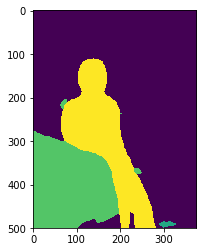

Probs


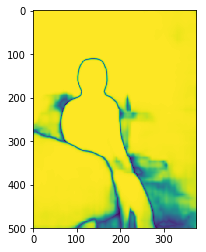

colored_class_image


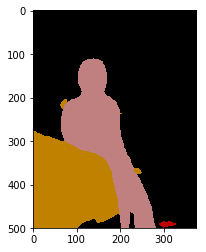

/home/baskar/Documents/DL/venv/lib/python3.5/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/baskar/Documents/DL/venv/lib/python3.5/site-packages/ipykernel_launcher.py:54: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/baskar/Documents/DL/venv/lib/python3.5/site-packages/ipykernel_launcher.py:55: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/baskar/Documents/DL/venv/lib/python3.5/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [14]:
from matplotlib import pyplot as plt
%matplotlib inline
main()

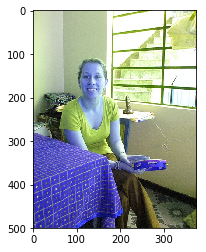

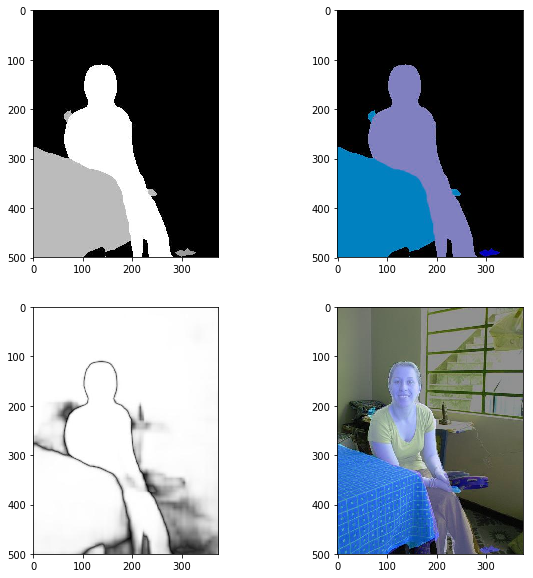

In [13]:
from matplotlib import pyplot as plt
%matplotlib inline
output_file = 'test1.jpg'
filename, ext = splitext(output_file)

file1 = filename + "_seg_read" + ext
file2 = filename + "_seg" + ext
file3 = filename + "_probs" + ext
file4 = filename + "_seg_blended" + ext

img1 = cv2.imread(file1)
img2 = cv2.imread(file2)
img3 = cv2.imread(file3)
img4 = cv2.imread(file4)
input_path = 'example_images/2007_000847.jpg'
img5 = cv2.imread(input_path)

plt.imshow(img5)
fig=plt.figure(figsize=(10, 10))
fig.add_subplot(2, 2, 1)
plt.imshow(img1)
fig.add_subplot(2,2,2)
plt.imshow(img2)
fig.add_subplot(2,2,3)
plt.imshow(img3)
fig.add_subplot(2,2,4)
plt.imshow(img4)

plt.show()

References:

https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

https://github.com/REFunction/VOC2012-Segmentation/blob/master/VOC2012.py

https://github.com/hszhao/PSPNet

https://github.com/Vladkryvoruchko/PSPNet-Keras-tensorflow

https://github.com/warmspringwinds/tf-image-segmentation
